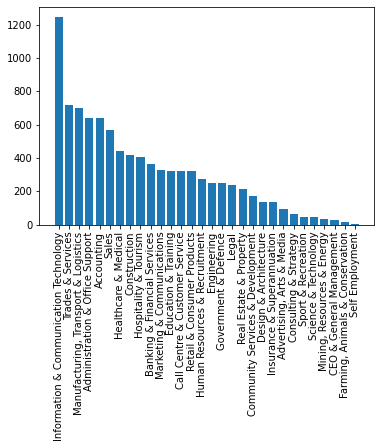

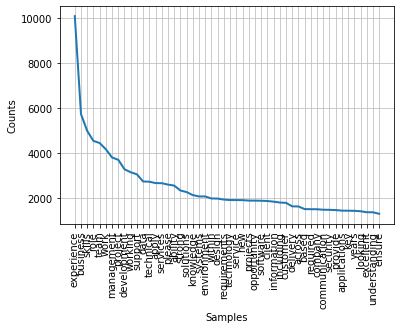

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [6]:
# DATASET EXPLORATION

import re
import matplotlib.pyplot as plt
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
import pandas as pd


# Generates a histogram showing frequency of job categories for a given city
def job_histogram(job_listings, city_name):
    job_listings = job_listings[job_listings['city'] == city_name.capitalize()]
    job_categories = set(job_listings['category'])
    histogram = {}
    for cat in job_categories:
        histogram[cat] = sum(job_listings['category'] == cat)
    return histogram  

# Showing frequency distribution of job listings
job_listings = pd.read_csv('seek_australia.csv')
hist = job_histogram(job_listings, 'Sydney')
labels, vals = zip(*sorted(hist.items(), key=lambda x: x[1], reverse=True))
plt.bar(range(len(vals)), vals, align='center')
plt.xticks(range(len(labels)), labels, size='medium', rotation=90)
plt.savefig('job_histogram.png', dpi=500, bbox_inches="tight")
plt.show()

# Generate word frequencies for the given category
def category_vocabulary(job_listings, category):
    stops = set(stopwords.words('english'))
    reg = re.compile('[^a-zA-Z0-9 ]')
    job_listings = job_listings[job_listings['category'] == category]
    all_words = []
    for job_desc in job_listings['job_description']:
        if type(job_desc) == str:
            job_desc = re.sub(reg, ' ', job_desc).lower()
            job_words = [tok for tok in word_tokenize(job_desc) 
                         if tok not in stops]
            all_words += job_words
    all_words = map(lambda x: x.lower(), all_words)
    return FreqDist(all_words)

fd = category_vocabulary(job_listings, 'Information & Communication Technology')
fd.plot(50)




In [8]:
# UTILITY FUNCTIONS

import re
from nltk import Tree, word_tokenize
from nltk.corpus import wordnet, stopwords
from string import punctuation, whitespace
from itertools import chain
punctuation = set(punctuation)
whitespace = set(whitespace)


# Recursive algorithm for generating an NLTK tree from a dependency parse
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(f'({node.text},{node.dep_},{node.pos_})', [to_nltk_tree(child) for child in node.children])
    else:
        return f'({node.text},{node.dep_},{node.pos_})'


# Prints dependency trees for the sentences in doc
def print_deps(doc):
    [to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]


# Obtains all synonyms of a string  
def get_synonyms(word): 
    synonyms = []
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.append(remove_punkt(l.name()))
    return set(synonyms)


# Removes punctuation from a string
def remove_punkt(text):
    reg = re.compile('[^a-zA-Z0-9 \n\.]')
    return re.sub(reg, ' ', text).lower()


# Removes stopwords from a string
def remove_stopwords(text):
    tokens = word_tokenize(text)
    return ' '.join([tok for tok in tokens if tok not in stopwords.words('english')])


# Calculates vocabulary size of a corpus
def calc_vocab_size(corpus):
    all_words = chain.from_iterable(corpus)
    reg = re.compile('[^a-zA-Z0-9]')
    vocab = [w for w in all_words if not re.search(reg, w)]
    print('Number of words:', len(vocab))
    return len(set(vocab))


# Returns a list of tokens where bigrams are merged
def merge_bigrams(tokens, bigrams):
    i = 0
    num_merged = 0
    merged_tokens = []
    while i < len(tokens) - 1:
        if (tokens[i], tokens[i + 1]) in bigrams:
            merged_tokens.append(tokens[i] + ' ' + tokens[i + 1])
            num_merged += 1
            i += 2
        else:
            merged_tokens.append(tokens[i])
            i += 1  
    return merged_tokens, num_merged


# Receives a list of sentences and splits sentences with length > max_sent_length, returning a new list of sentences
def retokenize_sents(sentences, max_sent_length):
    i = 0
    while i < len(sentences):
        sent = sentences[i]
        sub_sentences = []
        start_j = 0
        for j in range(0, len(sent)):
            if j - start_j > max_sent_length and sent[j] in whitespace:
                sub_sentences.append(sent[start_j:j])
                start_j = j 
        sub_sentences.append(sent[start_j:])  
            
        sentences[i] = sub_sentences[-1]
        for sub_sent in sub_sentences[::-1][1:]:
            sentences.insert(i, sub_sent.strip())
        i += len(sub_sentences)
    return sentences


# Joins a list of spans into a string by connecting via ;
def join_spans(sentences):
    summary = ''
    for sent in sentences[:-1]:
        summary += sent
        if summary[-1] in set([',', '.', '!', '?']):
            summary += ' '
        else:
            summary += '; '
    summary += sentences[-1]
    return summary

In [9]:
# INPUT PARSING

from spacy.matcher import PhraseMatcher

synonyms = {'job': get_synonyms('job'), 
            'experience': get_synonyms('experience')}             


# Preprocesses the input doc to merge compound words (e.g., software engineer)
def preprocess_input(doc, nlp):
    matcher = PhraseMatcher(nlp.vocab)
    with doc.retokenize() as retokenizer:
        # Merging full time and part time into single token
        def on_match(_, doc, id, matches):
            span = doc[matches[id][1]:matches[id][2]]
            employment_type = remove_punkt(span.text)
            attrs = {"TEXT": employment_type, "LEMMA": employment_type, 
                     'POS': 'ADJ', 'TAG': 'JJ', 'DEP': 'amod'}
            retokenizer.merge(span, attrs=attrs)
        
        terms = ['full-time', 'full time', 'part-time', 'part time']
        patterns = [nlp.make_doc(text) for text in terms]
        matcher.add("employment_types", patterns, on_match=on_match)
        matcher(doc)
        
    with doc.retokenize() as retokenizer:
        # Merging compound words into single token    
        for token in doc:
            j = token.i
            if j + 1 < len(doc):
                while doc[j].dep_ == "compound" and doc[j + 1].text not in synonyms['job']:
                    j += 1
                if j > token.i:
                    attrs = {"LEMMA": doc[token.i: j + 1].text}
                    try:
                        retokenizer.merge(doc[token.i: j + 1], attrs=attrs)
                    except ValueError as e:
                        print('Could not merge tokens: ', str(e))
      

# Extracts relevant attributes from the input doc via dependency parsing, stored inside 'user_prefs'
def extract_intent(doc, user_prefs):
    for token in doc:
        # EXTRACTING EMPLOYMENT TYPE
        # E.g., I want to work part-time
        if token.lemma_ in ['full time', 'part time', 'casual', 'casually', 'contract']:
            user_prefs['JOB_TYPE'] = token.text
        
        # EXTRACTING DESIRED JOB ATTRIBUTES
        # E.g., I want a job in software engineering in Seattle. I want to work for Google
        if 'NN' in token.tag_:
            compound_attribute = token.dep_ == 'compound' and doc[token.i + 1].text in synonyms['job']  
            not_experience = 'experience' not in set(tok.lower_ for tok in token.ancestors)
            
            if token.dep_ == 'pobj' and not_experience:
                if token.ent_type_ == 'ORG' and doc[token.i - 1].text not in ['a', 'an']:
                    user_prefs['COMPANY'].append(token.text)
                elif token.ent_type_ == 'GPE' and doc[token.i - 1].text == 'in':
                    user_prefs['LOCATION'].append(token.text)
                elif token.head.text in ['for', 'in', 'to', 'as']:
                    job_words = [adj.text for adj in token.children if adj.dep_ == 'amod'] + [token.text]
                    user_prefs['JOB'].append(' '.join(job_words))
                        
            elif compound_attribute or token.dep_ == 'npadvmod' or token.dep_ == 'attr':
                if token.ent_type_ == 'ORG':
                    user_prefs['COMPANY'].append(token.text)
                elif token.ent_type_ == 'GPE':
                    user_prefs['LOCATION'].append(token.text)
                else:
                    job_words = [adj.text for adj in token.children if adj.dep_ == 'amod'] + [token.text]
                    user_prefs['JOB'].append(' '.join(job_words))
        
        # EXTRACTING AMOUNT OF EXPERIENCE
        # E.g., I have 10 years of experience in bakery
        is_correct_head = token.text == 'years' or token.text == 'months' \
                            or token.text in synonyms['experience']
        if is_correct_head and token.dep_ == 'dobj':
            subtree = list(token.subtree)
            experiences = doc[subtree[0].i : subtree[-1].i + 1]
            user_prefs['EXPERIENCE'].append(experiences.text)
        
        # EXTRACTING LIST OF EXPERIENCES 
        # E.g., My experience includes sql, database, and c++
        if token.dep_ == 'nsubj' and token.text in synonyms['experience']:
            [dobj] = [child for child in token.head.rights if child.dep_ == 'dobj']
            subtree = list(dobj.subtree)
            experiences = doc[subtree[0].i : subtree[-1].i + 1]
            user_prefs['EXPERIENCE'].append(experiences.text)


/home/allenator/anaconda3/envs/cits4012/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# DATASET PREPROCESSING

import os
import re
import pickle
import numpy as np
import pandas as pd
from string import punctuation, whitespace
from itertools import chain
from collections import defaultdict
from heapq import nlargest

from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk import word_tokenize, sent_tokenize, edit_distance
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.collocations import *

from utils import get_synonyms, calc_vocab_size, merge_bigrams, retokenize_sents, join_spans

stopwords = set(stopwords.words('english'))
punctuation = set(punctuation)
whitespace = set(whitespace)


# Evaluates user input against against tfidf matrices, produced from the processed dataset and filtered by the supplied attribute 
# parameters (city, company_name, job_title). This function generates a list of (dataframe index: job summary) 
# pairs, ordered by their relevance to the passed 'user_input' string.
def find_closest_jobs(user_input, job_categories,  city=None, company_name=None, job_type=None, score_thresh=0.05):
    all_cat_scores = []
    
    for category in job_categories:
        pruned_df = jobs_dataframe[jobs_dataframe.category.eq(category)]
        if city:
            pruned_df = pruned_df[pruned_df.city.eq(city)]
        if company_name:
            pruned_df = pruned_df[pruned_df.company_name.eq(company_name)]
        if job_type:
            pruned_df = pruned_df[pruned_df.job_type.eq(job_type)]
        
        category_data = preprocessed_data[category]
        tfidf = category_data['tfidf']
        tfidf_matrix = category_data['tfidf_matrix']
        dictionary = category_data['dictionary']
        df_indices = category_data['df_indices']    # A list of data frame row indices corresponding to the docs in the corpus
        bigrams = category_data['bigrams']
        
        # Filter docs which are invalidated by city, and job_type
        valid_indices = [(i, df_ind) for i, df_ind in enumerate(df_indices) if df_ind in set(pruned_df.index.values)]
        corp_indices, df_indices = zip(*valid_indices)
        tfidf_matrix = [tfidf_matrix[i] for i in corp_indices]
        
        # Construct sparse embeddings
        embeddings = []
        for doc in tfidf_matrix:
            scores_dict = dict(doc)
            embeddings.append([scores_dict.get(id, 0) for id in range(len(dictionary))])
            
        input_tokens = process_doc(user_input, bigrams)
        input_BoW = dictionary.doc2bow(input_tokens)
        input_score_dict = dict(tfidf[input_BoW])
        input_embedding = [[input_score_dict.get(id, 0) for id in range(len(dictionary))]]
        
        cosine_scores = cosine_similarity(input_embedding, embeddings).flatten()
        job_listing_scores = filter(lambda x: x[1] > score_thresh, zip(df_indices, cosine_scores))
        all_cat_scores.extend(job_listing_scores)
        
    get_desc = lambda i: jobs_dataframe['job_description'].loc[i]
    all_cat_scores = sorted(all_cat_scores, key=lambda x: x[1], reverse=True)
    top_score = all_cat_scores[0][1] if all_cat_scores else 0
    summaries = [(df_ind, summarize_description(get_desc(df_ind), bigrams, dictionary, tfidf)) for df_ind, _ in all_cat_scores]
    return summaries, top_score


# Finds the closest column names to a list of input attributes, and the distance metrics to those input attributes
def find_closest_columns(nlp, jobs, locations=[], companies=[], job_type=''):
    if jobs == []:
        raise ValueError('There must be at least one job description')
    
    out_data = {'categories': [], 'location': None, 'location_score': -1, 'company_name': None, 
                'company_score': -1, 'job_type': None}
    category_docs = [nlp(cat.lower()) for cat in set(jobs_dataframe['category'])]
    job_docs = [nlp(job) for job in jobs]
    category_scores = {cat: max([cat.similarity(job) for job in job_docs]) for cat in category_docs}
    best_cats = sorted(category_scores, key=category_scores.get, reverse=True)
    best_cats = [cat.text.title() for cat in best_cats[:3]]
    out_data['category'] = best_cats
         
    if locations != []:
        locations = [loc.title() for loc in locations]
        city_scores = {city: min([edit_distance(loc, city) for loc in locations]) for city in set(jobs_dataframe['city'])}
        best_loc, best_score = sorted(city_scores.items(), key=lambda x: x[1])[0]
        if best_score == 0:
            out_data['location'] = best_loc
        out_data['location_score'] = best_score
    
    if companies != []:
        companies = [comp.title() for comp in companies]
        comp_scores = {df_comp: min([edit_distance(comp, df_comp) for comp in companies]) for df_comp in set(jobs_dataframe['city'])}
        best_company, best_score = sorted(comp_scores.items(), key=lambda x: x[1])[0]
        if best_score < 2:
            out_data['company_name'] = best_company
        out_data['company_score'] = best_score
    
    if job_type != '':
        job_type = job_type.title()
        possible_types = set(jobs_dataframe['job_type'])
        best_job_type = sorted(possible_types, key=lambda x: edit_distance(x, job_type))[0]
        out_data['job_type'] = best_job_type
    
    return out_data
        

# Preprocesses all the categories in the csv file (by calling 'preprocess_category'),
# and stores the results in a pickle file.   
def preprocess(csv_name, file_name):
    df = pd.read_csv(csv_name).drop_duplicates(subset='job_description')
    df = df[df['job_description'].notnull()]
    preprocessed_data = {}
    categories = set(df['category'])
    print('Preprocessing:\n')
    for i, category in enumerate(categories):
        print(f'=========> {i / len(categories) * 100:.2f} / 100 %', end='\r')
        preprocessed_data[category] = preprocess_category(df, category)
    pickle.dump(preprocessed_data, open(file_name, 'wb'))  


# Preprocesses the dataframe data for a single category, performing in order tokenization;
# lemmatization/stemming; obtaining frequent collocations via student's t-test; merging collocations, 
# and finally generating the tfidf matrix. By setting verbose=True, 
# the function will print out the vocabulary size at each step.
def preprocess_category(job_listings, category, verbose=False):
    job_listings = job_listings[job_listings['category'] == category]
    job_descriptions = job_listings['job_description']
    
    # Tokenization
    reg = re.compile('[^a-zA-Z0-9 !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]')
    corpus = [word_tokenize(re.sub(reg, ' ', job_desc).lower())
              for job_desc in job_descriptions]
    df_indices = list(job_descriptions.index)
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_corpus = [[lemmatizer.lemmatize(w) for w in doc] for doc in corpus]
    
    # Stemming
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    stemmed_corpus = [[stemmer.stem(w) for w in doc] for doc in corpus]
    
    # Obtaining collocations
    all_words = chain.from_iterable(lemmatized_corpus)
    bigram_finder = BigramCollocationFinder.from_words(all_words)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    
    def bigram_filter(*toks):
        if toks[0] in stopwords or toks[-1] in stopwords:
            return True
        if np.any([re.search('[^a-zA-Z0-9]', tok) for tok in toks]):
            return True
    
    bigram_finder.apply_ngram_filter(bigram_filter)
    bigrams = set(bigram_finder.above_score(bigram_measures.student_t, 4.5))
    
    # Removing punctuation
    for doc in lemmatized_corpus:
        for i, token in enumerate(doc):
            reg = re.compile('[^a-zA-Z0-9]')
            tokens = re.split(reg, token)[::-1]
            doc[i] = tokens[0]
            for tok in tokens[1:]:
                doc.insert(i, tok)
    
    # Further filtering
    lemmatized_corpus = [[w for w in doc if w.isalpha() and len(w) > 1] 
                       for doc in lemmatized_corpus]
    
    # Merge collocations in tokens
    corpus_merged_bigrams = []
    num_bigrams = 0
    for doc in lemmatized_corpus:
        merged_tokens, num_merged = merge_bigrams(doc, bigrams)
        corpus_merged_bigrams.append(merged_tokens)
        num_bigrams += num_merged     
    
    # Compute tfidf matrix
    dictionary = Dictionary()
    BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in corpus_merged_bigrams]
    tfidf = TfidfModel(BoW_corpus, smartirs='ntc')
        
    if verbose:
        print(f'Initial vocabulary size is {calc_vocab_size(corpus)}')
        print(f'Vocabulary size after lemmatization is {calc_vocab_size(lemmatized_corpus)}')
        print(f'Vocabulary size after stemming is {calc_vocab_size(stemmed_corpus)}')
        print('Total number of merged bigrams:', num_bigrams)  
        print(f'Vocabulary size after merging collocations is {calc_vocab_size(corpus_merged_bigrams)}')
        
    return {'tfidf': tfidf, 'tfidf_matrix': tfidf[BoW_corpus], 'dictionary': dictionary, 'df_indices': df_indices, 'bigrams': bigrams}


# Performs tokenization, lemmatization, punctuation removal, and 
# collocation merging on a single document.
def process_doc(input_str, bigrams):
    # Tokenization
    reg = re.compile('[^a-zA-Z0-9 !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]')
    tokens = word_tokenize(re.sub(reg, '', input_str).lower())
    
    # Lemmatization 
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
    
    # Removing punctuation
    for i, token in enumerate(tokens):
        reg = re.compile('[^a-zA-Z0-9]')
        new_toks = re.split(reg, token)[::-1]
        tokens[i] = new_toks[0]
        for tok in new_toks[1:]:
            tokens.insert(i, tok)
            
    # Alphanumeric filtering
    tokens = [tok for tok in tokens if tok.isalpha() and len(tok) > 1] 
    
    # Merging collocations
    tokens, _ = merge_bigrams(tokens, bigrams)
    return tokens


# Uses the tfidf values of words to weight sentences within the job description,
# and combines the strongest sentences n to produce a summary of the job description.
def summarize_description(description, bigrams, dictionary, tfidf, n=3):
    reg = re.compile('[^a-zA-Z0-9 !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]')
    description = re.sub(reg, '', description)
    
    word_weightings = {'role': 1.25, 'experience': 1.25, 'skill': 1.25, 'require': 1.5, 'contact': 2, 'email': 2.25}
    
    BoW = dictionary.doc2bow(process_doc(description, bigrams))
    tfidf_scores = dict(tfidf[BoW])
    word2score = {dictionary[key]: score for key, score in tfidf_scores.items()}
    sentences = sent_tokenize(description)
    sentences = retokenize_sents(sentences, max_sent_length=200)
    
    sentence_scores = defaultdict(int)
    for doc in sentences[1:-1]:
        tokens = process_doc(doc, bigrams)
        for tok in tokens:
            sentence_scores[doc] += word2score.get(tok, 0)
            for syn in get_synonyms(tok.lower()):
                sentence_scores[doc] *= word_weightings.get(syn, 1)
    
    summarized_spans = nlargest(n, sentence_scores, key=sentence_scores.get)
    if sentences[0] not in summarized_spans:
        summarized_spans.insert(0, sentences[0])
    if sentences[-1] not in summarized_spans:
        summarized_spans.append(sentences[-1])
    return join_spans(summarized_spans)
               

if os.path.exists('preprocessed_category_data.pkl'):
    jobs_dataframe = pd.read_csv('seek_australia.csv').drop_duplicates(subset='job_description')
    jobs_dataframe = jobs_dataframe[jobs_dataframe['job_description'].notnull()]
    preprocessed_data = pickle.load(open('preprocessed_category_data.pkl', 'rb'))
else:
    preprocess(csv_name='seek_australia.csv', file_name='preprocessed_category_data.pkl')

In [1]:
import re
import random
from telegram.ext import Updater, MessageHandler, Filters
from itertools import chain
from copy import deepcopy
from process_dataset import find_closest_columns, find_closest_jobs, jobs_dataframe
from process_input import preprocess_input, extract_intent
from utils import get_synonyms
import spacy


nlp = spacy.load('en_core_web_md')
synonyms = {'hello': get_synonyms('hello')}
TOKEN = '5253730200:AAGWl7KNYtp5FoxjEC6JkpLCdbtuqWTSVnY'

base_user_prefs = {
    'JOB': [],
    'COMPANY': [],
    'LOCATION': [],
    'EXPERIENCE': [],
    'JOB_TYPE': ''
    }   

# The main message hander. Called after the chatbot receives a message.
def utterance(update, context):
    global user_prefs; global best_match
    
    reg = reg = re.compile('[^a-zA-Z0-9 !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]')
    msg = update.message.text
    re.sub(reg, msg, '')
    # Welcome message
    if msg.lower() in synonyms['hello']:
        update.message.reply_text("Hello! Welcome to a simple job seeking chat bot. Send a message if you would like to begin a query. " + 
                                    "If you would like to reset your current search query, send 'reset'. If you would like to undo your last message from " +
                                    "your current query, send 'undo'.")
    # Reset the user's current search query and query history.
    elif msg.lower() == 'reset':
        update.message.reply_text("You have reset your current search query and your query history. Send a new message to begin a new search.")
        reset_user_prefs()
    # View current query  
    elif msg.lower() == 'view':
        if len([key for key in user_prefs.keys() if user_prefs[key]]) > 0:
            send_affirmation(update)
        else:
            update.message.reply_text("Your current query is empty and cannot be viewed. Please send a message to begin a new query.")
    # Undo last message from current query.
    elif msg.lower() == 'undo':
        if len(user_prefs_history) < 2:
            update.message.reply_text("Your current query is empty. Please send a message to begin a new query.")
        else:
            print(user_prefs_history)
            user_prefs = user_prefs_history.pop()
            update.message.reply_text("You have undone your previous message from the current query. This is the current state of your query:")
            send_affirmation(update)
            create_query(msg, update)
    # Send current best match     
    elif msg.lower() == 'best match':
        send_best_match(update)
    # Iterate through to the next best match, and send the best match.
    elif msg.lower() == 'next':
        if len(matches) == 0:
            update.message.reply_text("There are no other matches remaining. Please send a message to begin a new query.")
        else:
            update.message.reply_text("You have selected to continue to the next best match")
            best_match = matches.pop(0)
            send_best_match(update)
    # Stops the chatbot. Alternative to Ctrl-Z which doesn't kill process.
    elif msg.lower() == 'stop':
        updater.stop()
        updater.is_idle = False
    # Create a query from the message and obtain a list of matches.
    else:
        if len(user_prefs_history) == 0 or user_prefs != user_prefs_history[-1]:
            user_prefs_history.append(deepcopy(user_prefs))
        create_query(msg, update)
            

# Sends information pertaining to the currently defined best job match.
def send_best_match(update):
    update.message.reply_text(f"The current best match is a {best_match['job_type']} position called '{best_match['job']}'. You will be working for " + 
                                  f"{best_match['company']}, in {best_match['city']}. Here is a summary of the job:\n\n{best_match['summary']}")
    update.message.reply_text("Please continue sending messages to refine your query. If you would like to view the next best match, send 'next'. " + 
                              "If you would like to start a new query, send 'reset'.")
    

# Updates the best matches based on the passed variable called 'closest_jobs'.
def update_best_matches(closest_jobs):
    global matches; global best_match
    df_indices, top_summaries = zip(*closest_jobs)
    df_arr = jobs_dataframe[['city', 'company_name', 'job_title', 'job_type']].loc[list(df_indices)].to_numpy()
    matches = [{'city': city, 'company': company, 'job': job, 'job_type': job_type, 'summary': top_summaries[i]}
               for i, (city, company, job, job_type) in enumerate(df_arr)]
    best_match = matches.pop(0)


# Resets user preferences and query history.
def reset_user_prefs():
    global user_prefs; global user_prefs_history
    user_prefs = deepcopy(base_user_prefs)
    user_prefs_history = []
    
    
# Creates a query based on the passed message string, sending an affirmation, and sending the most relevant jobs.   
def create_query(msg, update):
    doc = nlp(msg) 
    preprocess_input(doc, nlp)
    extract_intent(doc, user_prefs)
    unfilled_keys = [key for key in user_prefs.keys() if not user_prefs[key]]
    print(user_prefs)
    
    if len(unfilled_keys) == 5 or user_prefs == user_prefs_history[-1]:
        update.message.reply_text("Sorry, I could not understand your message. Please repeat with different wording.")
        return
        
    # Affirm the information the user has submitted
    send_affirmation(update)
    update.message.reply_text('Processing your query...')
    
    if 'JOB' in unfilled_keys:
        update.message.reply_text("Sorry, I could not decipher the particular job category or occupation name you are looking for. " + 
                                  "Please include this in your next message.")
        return
    
    # Create data to be processed
    user_input = ' '.join(chain(*user_prefs.values()))
    job_vals = [job for job in user_prefs['JOB']]
    loc_vals = [loc for loc in user_prefs['LOCATION']]
    comp_vals = [loc for loc in user_prefs['COMPANY']]
    
    column_data = find_closest_columns(nlp, job_vals, loc_vals, comp_vals, user_prefs['JOB_TYPE'])
    closest_jobs, top_cosine_score = find_closest_jobs(user_input, column_data['category'], column_data['location'], 
                                        column_data['company_name'], column_data['job_type'])
    if len(closest_jobs) > 0: 
        update_best_matches(closest_jobs)
    print('Identified job categories:', column_data['category'])
    
    # Present results of the search
    if len(closest_jobs) == 0:
        update.message.reply_text("Sorry, I could not find any jobs that match your previous query. Your query has been reset. Please re-try your query.")
        reset_user_prefs()
        
    elif top_cosine_score < 0.20:
        update.message.reply_text(f"Good news! I have found {len(closest_jobs)} jobs that match your query. Please help refine the list by sending additional " + 
                                  "messages. If you would like to receive the current best match send 'best match'.")
        if column_data['location_score'] >= 2:
            update.message.reply_text(f"- Unfortunately, the locations you supplied do not match any of the jobs I have found. " + 
                                      "Please supply additional locations to narrow your search. Locations should be cities in Australia")
        if column_data['company_score'] >= 3:
            update.message.reply_text(f"- The companies you supplied do not match any of the jobs I have found. " + 
                                      "Please supply additional companies to narrow your search.")
        if unfilled_keys:
            update.message.reply_text("- The following information is missing from your query. Please expand your query to add these " + 
                                        f"attributes: {', '.join(unfilled_keys)}")
            
    else:
        update.message.reply_text("Good news! I have found a job that meets the sufficient similarity criteria.") 
        send_best_match(update)
        update.message.reply_text("Would you like to refine your query? If so, please continue sending messages to add to your query. " + 
                                    "If you would like to start a new query, send 'reset'.")
         

# Parses the user query, produces a summary of the user's preferences in the chatbot's own words, and sends it.
def send_affirmation(update):
    sentence_starters = ['it appears,', 'from my understanding,', 'from my predictions,', 'I see,', 'it seems']
    transition_words = ['also,', 'in addition,', 'furthermore,', 'on top of that,', 'as well as that,']
    sentences = []
    
    known_attributes = [key for key, val in user_prefs.items() if type(val) == list and val != []]
    random.shuffle(known_attributes)
    job_type = user_prefs['JOB_TYPE']
    
    for attr in known_attributes:
        if attr == 'JOB':
            for token in user_prefs['JOB']:
                job_phrase = job_type + ' ' + token if job_type else token
                if token.endswith('e') or token.endswith('ing'):
                    ling_pattern = random.choice(['pobj', 'compound', 'npadvmod'])
                    if ling_pattern == 'npadvmod':
                        job_str = f'you want a {job_phrase} based job'
                    else:
                        job_str = produce_base_sentence(ling_pattern, job_phrase, ['pobj', 'compound'])
                else:
                    ling_pattern = random.choice(['pobj', 'compound'])
                    if ling_pattern == 'pobj':
                        job_str = f'you want to work as a {job_phrase}'
                    else:
                        job_str = produce_base_sentence(ling_pattern, job_phrase, ['compound'])
                sentences.append(job_str)
                
        elif attr == 'LOCATION':
            for token in user_prefs['LOCATION']:
                ling_pattern = random.choice(['pobj', 'compound', 'npadvmod', 'attr'])
                if ling_pattern == 'attr':
                    loc_str = f'you want your location to be {token}'
                else:
                    loc_str = produce_base_sentence(ling_pattern, token, ['pobj', 'compound', 'npadvmod'])
                sentences.append(loc_str)
                
        elif attr == 'COMPANY':
            for token in user_prefs['COMPANY']:
                ling_pattern = random.choice(['pobj', 'compound', 'npadvmod'])
                if ling_pattern == 'pobj':
                    loc_str = f'you want to work for {token}'
                elif ling_pattern == 'attr':
                    loc_str = f'you want your company to be {token}'
                comp_str = produce_base_sentence(ling_pattern, token, ['compound'])
                sentences.append(comp_str)

        elif attr == 'EXPERIENCE':
            for token in user_prefs['EXPERIENCE']:
                exp_str = f'you have {token}'.strip('.')
                sentences.append(exp_str)
    
    for i in range(len(sentences)):
        starter = random.choice(sentence_starters)
        sentences[i] = starter + ' ' + sentences[i]
        if i > 0 and i < len(sentences) - 1:
            transition = random.choice(transition_words)
            sentences[i] = transition + ' ' + sentences[i]
        elif i == len(sentences) - 1 and len(sentences) > 3:
            sentences[i] = 'finally,' + ' ' + sentences[i]
        sentences[i] = sentences[i][0].upper() + sentences[i][1:]
        text = '. '.join(sentences) + '.'
    update.message.reply_text(text)
    

# Helper function to predefine sentences for summarizing the user query.
def produce_base_sentence(pattern, word, possible_patterns):
    if pattern == 'pobj' and 'pobj' in possible_patterns:
        s = f'you want to work in {word}'
    if pattern == 'compound' and 'compound' in possible_patterns:
        s = f'you want a {word} job'
    if pattern == 'npadvmod' and 'npadvmod' in possible_patterns:
        s = f'you want a {word} based job'
    if pattern == 'attr' and 'attr' in possible_patterns:
        s = f'you want to be a {word}'
    return s
         
            
reset_user_prefs()
user_prefs_history = []

updater = Updater(TOKEN, use_context=True)
updater.dispatcher.add_handler(MessageHandler(Filters.text, utterance))
updater.start_polling()
print('Running...')
updater.idle()

/home/allenator/anaconda3/envs/cits4012/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running...
{'JOB': ['software engineer'], 'COMPANY': [], 'LOCATION': ['Perth'], 'EXPERIENCE': [], 'JOB_TYPE': ''}
Identified job categories: ['Engineering', 'Consulting & Strategy', 'Information & Communication Technology']
